<a href="https://colab.research.google.com/github/gongx030/etv2_pioneer/blob/master/Test_accessibility_MEF_D1_Etv2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Identifying the Etv2 binding sites that cause significantly chromatin accessibility changes from MEF to D1 in Etv2 induced reprogramming
by Wuming Gong


In [233]:
start_time0 <- Sys.time()

In [234]:
options(max.print=1000)

### Install external packages

In [235]:
system('apt-get -q install libgsl-dev', intern = TRUE)

[1] "Reading package lists..."                                       
[2] "Building dependency tree..."                                    
[3] "Reading state information..."                                   
[4] "libgsl-dev is already the newest version (2.4+dfsg-6)."         
[5] "0 upgraded, 0 newly installed, 0 to remove and 12 not upgraded."

In [236]:
system('apt-get install libcairo2-dev', intern = TRUE) # for Cairo package that is required by ComplexHeatmap package

[1] "Reading package lists..."                                         
[2] "Building dependency tree..."                                      
[3] "Reading state information..."                                     
[4] "libcairo2-dev is already the newest version (1.15.10-2ubuntu0.1)."
[5] "0 upgraded, 0 newly installed, 0 to remove and 12 not upgraded."

## Install and load R packages

In [237]:
install.packages('BiocManager')

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [238]:
required_packages <- c(
  'devtools', 'BiocManager',
  'BSgenome.Mmusculus.UCSC.mm10'
)

In [239]:
missing_packages <- required_packages[!required_packages %in% rownames(installed.packages())]
if (length(missing_packages) > 0){
    BiocManager::install(missing_packages)
}

In [240]:
library(devtools)

### Install the `seatac` package

In [241]:
install_github('gongx030/seatac', auth_token = '1ec80806b12d3ff2416826d69f13b74adb5188ae', force = TRUE, quiet = FALSE, ref = 'development')
reload(pkgload::inst("seatac"))
library(seatac)


✔  checking for file ‘/tmp/RtmppiKpBh/remotes4a53b6ecc2/gongx030-seatac-7adc0476536a3a3f4078ec972930d76d8c33daad/DESCRIPTION’ (433ms)
─  preparing ‘seatac’:
✔  checking DESCRIPTION meta-information
─  checking for LF line-endings in source and make files and shell scripts
─  checking for empty or unneeded directories
─  building ‘seatac_0.3.25.tar.gz’
   


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Reloading attached seatac


Attaching package: ‘seatac’


The following object is masked from ‘package:tfdatasets’:

    fit




In [242]:
library(dplyr)
library(GenomicRanges)
library(BSgenome.Mmusculus.UCSC.mm10)
library(gplots) # colorpanel
library(ggplot2)

## Download the ATAC-seq BAM files for undifferentiated MEF and D1 post Etv2 induction.

In [243]:
bam_files <- c(
  'MEF_Dox_D1' = 'https://s3.msi.umn.edu/gongx030/datasets/dataset=Etv2ATAC_version=20190228b/MEF_Dox_D1.bam',
# 'MEF_Dox_D2' = 'https://s3.msi.umn.edu/gongx030/datasets/dataset=Etv2ATAC_version=20190228b/MEF_Dox_D2.bam',
# 'MEF_Dox_D7' = 'https://s3.msi.umn.edu/gongx030/datasets/dataset=Etv2ATAC_version=20190228b/MEF_Dox_D7.bam',
# 'MEF_Dox_D7_Flk1pos' = 'https://s3.msi.umn.edu/gongx030/datasets/dataset=Etv2ATAC_version=20190228b/MEF_Dox_D7_Flk1pos.bam',
  'MEF_NoDox' = 'https://s3.msi.umn.edu/gongx030/datasets/dataset=Etv2ATAC_version=20190228b/MEF_NoDox.bam'
# 'MEF_Brg1_KD_D0' = 'https://s3.msi.umn.edu/gongx030/datasets/dataset=Brg1KO_MEF_reprogramming_version=20200817a/MEF_Brg1_KD_D0.bam',
# 'MEF_Brg1_KD_Dox_D1' = 'https://s3.msi.umn.edu/gongx030/datasets/dataset=Brg1KO_MEF_reprogramming_version=20200817a/MEF_Brg1_KD_Dox_D1.bam',
# 'MEF_Brg1_KD_Dox_D2' = 'https://s3.msi.umn.edu/gongx030/datasets/dataset=Brg1KO_MEF_reprogramming_version=20200817a/MEF_Brg1_KD_Dox_D2.bam',
# 'MEF_Brg1_KD_Dox_D7' = 'https://s3.msi.umn.edu/gongx030/datasets/dataset=Brg1KO_MEF_reprogramming_version=20200817a/MEF_Brg1_KD_Dox_D7.bam',
# 'MEF_Brg1_KD_NoDox_D1' = 'https://s3.msi.umn.edu/gongx030/datasets/dataset=Brg1KO_MEF_reprogramming_version=20200817a/MEF_Brg1_KD_NoDox_D1.bam',
# 'MEF_Brg1_KD_NoDox_D2' = 'https://s3.msi.umn.edu/gongx030/datasets/dataset=Brg1KO_MEF_reprogramming_version=20200817a/MEF_Brg1_KD_NoDox_D2.bam',
# 'MEF_Brg1_KD_NoDox_D7' = 'https://s3.msi.umn.edu/gongx030/datasets/dataset=Brg1KO_MEF_reprogramming_version=20200817a/MEF_Brg1_KD_NoDox_D7.bam'
)

In [244]:
local_bam_files <- gsub('https://s3.msi.umn.edu/', './', bam_files)

In [245]:
# download BAM file
commands <- sprintf('wget -x -c -nH %s', bam_files)
res <- lapply(commands, function(command) system(command))

## Read the Etv2 ChIP-seq binding sites during the reprogramming

Define the peak window size

In [246]:
window_size <- 800L

In [247]:
gr <- 'https://s3.msi.umn.edu/gongx030/datasets/dataset=Etv2PioneerChIPseq_version=20191203a/all_Etv2_peaks.rds'
gr <- readRDS(gzcon(url(gr)))
gr <- gr %>% resize(width = window_size, fix = 'center')
gr <- gr[!seqnames(gr) %in% c('chrM', 'chrY')]
sprintf('total number of Etv2 peaks: %d', length(gr)) %>% message()

total number of Etv2 peaks: 161481



Get the Etv2 ChIP-seq binding sites that are present at D1 post induction

In [248]:
gr <- gr[mcols(gr)$group[, 'MEF_Dox_d1_Etv2']]
sprintf('total number of Etv2 peaks at D1: %d', length(gr)) %>% message()

total number of Etv2 peaks at D1: 123021



In [249]:
gr

GRanges object with 123021 ranges and 4 metadata columns:
           seqnames              ranges strand |                peak_id
              <Rle>           <IRanges>  <Rle> |            <character>
       [1]     chr1     3037484-3038283      * | /panfs/roc/scratch/g..
       [2]     chr1     3490014-3490813      * | /panfs/roc/scratch/g..
       [3]     chr1     3531326-3532125      * | /panfs/roc/scratch/g..
       [4]     chr1     3670825-3671624      * | /panfs/roc/scratch/g..
       [5]     chr1     3671446-3672245      * | /panfs/roc/scratch/g..
       ...      ...                 ...    ... .                    ...
  [123017]     chrX 170829184-170829983      * | /panfs/roc/scratch/g..
  [123018]     chrX 170851271-170852070      * | /panfs/roc/scratch/g..
  [123019]     chrX 170854959-170855758      * | /panfs/roc/scratch/g..
  [123020]     chrX 170858587-170859386      * | /panfs/roc/scratch/g..
  [123021]     chrX 170880751-170881550      * | /panfs/roc/scratch/g..
      

## Read the Vplot of each window

In [250]:
bin_size <- 10L
fragment_size_interval <- 10L
fragment_size_range <- c(80L, 320L)

In [252]:
x <- gr %>% 
  read_vplot(
    local_bam_files, 
    genome = BSgenome.Mmusculus.UCSC.mm10, 
    bin_size = bin_size, 
    fragment_size_range = fragment_size_range, 
    fragment_size_interval = fragment_size_interval
  )

Warning message:
“  Using providerVersion() on a BSgenome object is deprecated. Please use
  'metadata(x)$genome' instead.”
read_bam | reading ./gongx030/datasets/dataset=Etv2ATAC_version=20190228b/MEF_Dox_D1.bam

Warning message:
“  Using providerVersion() on a BSgenome object is deprecated. Please use
  'metadata(x)$genome' instead.”
Warning message:
“  Using providerVersion() on a BSgenome object is deprecated. Please use
  'metadata(x)$genome' instead.”
read_bam | reading ./gongx030/datasets/dataset=Etv2ATAC_version=20190228b/MEF_NoDox.bam

Warning message:
“  Using providerVersion() on a BSgenome object is deprecated. Please use
  'metadata(x)$genome' instead.”


`x` is a `Vplots` object (which inherits `RangedSummarizedExperiment`) that include the Vplot data in `assays(x)$counts`.  Since Vplots are very sparse, the `assays(x)$counts` is stored as a `dgCMatrix` object, which the dimension `[batch, width * height]`. 

Since the ATAC-seq data from different experiments usually have different [fragment size distribution](https://dbrg77.wordpress.com/2017/02/10/atac-seq-insert-size-plotting/), such a batch effect must be taken into account when fitting the VAE model.  The batch indiator is stored in `rowData(x)$batch` as character vector, which are the names of input bam files (e.g. `names(local_bam_files)`).  So it is important to assign unique names to each bam files in `local_bam_files`.  

In [253]:
x

class: Vplots 
dim: 246042 1920 
metadata(0):
assays(1): counts
rownames: NULL
rowData names(6): peak_id score ... id batch
colnames: NULL
colData names(0):
## fragment_size_range:80,320
## fragment_size_interval:10
## n_intervals:24
## bin_size:10
## window_size:800
## n_bins_per_window:80
## n_samples:2
## samples:MEF_Dox_D1,MEF_NoDox

## Define the VAE model

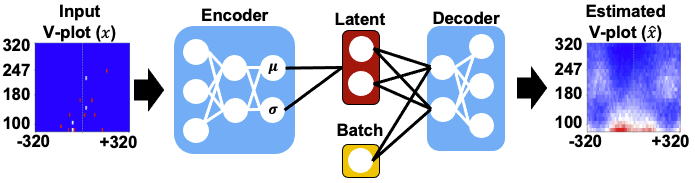

In [254]:
latent_dim <- 10L
filters0 <- 128L
block_size <- 640L # width of the Vplot

In [255]:
model <- new('VaeModel', model = VaeModel(
  latent_dim = latent_dim,
  block_size = block_size,
  bin_size = bin_size,
  filters0 = filters0,
  fragment_size_range = fragment_size_range,
  fragment_size_interval = fragment_size_interval
))

## Train the VAE model

In [256]:
model <- model %>% fit(
  x, 
  batch_size = 1024L, 
  epochs = 500L, 
  warmup = 100L, 
  compile = TRUE, 
  learning_rate = 1e-4, 
  max_training_samples = 50000L,  # max number of Vplots for training
  min_reads = 25L,  # min number of reads of the Vplots for training
  step_size = 20L
)

dimnames(.) <- NULL:  translated to 
dimnames(.) <- list(NULL,NULL)  <==>  unname(.)

slidingWindows | batch=   1/  61

dimnames(.) <- NULL:  translated to 
dimnames(.) <- list(NULL,NULL)  <==>  unname(.)

slidingWindows | batch=   2/  61

dimnames(.) <- NULL:  translated to 
dimnames(.) <- list(NULL,NULL)  <==>  unname(.)

slidingWindows | batch=   3/  61

dimnames(.) <- NULL:  translated to 
dimnames(.) <- list(NULL,NULL)  <==>  unname(.)

slidingWindows | batch=   4/  61

dimnames(.) <- NULL:  translated to 
dimnames(.) <- list(NULL,NULL)  <==>  unname(.)

slidingWindows | batch=   5/  61

dimnames(.) <- NULL:  translated to 
dimnames(.) <- list(NULL,NULL)  <==>  unname(.)

slidingWindows | batch=   6/  61

dimnames(.) <- NULL:  translated to 
dimnames(.) <- list(NULL,NULL)  <==>  unname(.)

slidingWindows | batch=   7/  61

dimnames(.) <- NULL:  translated to 
dimnames(.) <- list(NULL,NULL)  <==>  unname(.)

slidingWindows | batch=   8/  61

dimnames(.) <- NULL:  translated to 
dim

## Exatract the center Vplots

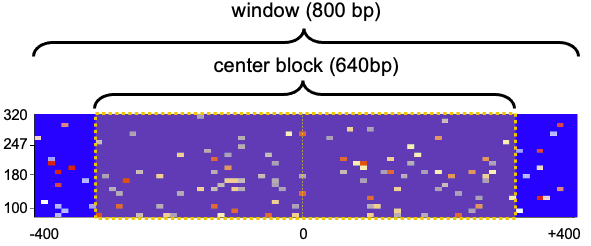

Randomly sample 20,000 Vplot for testing

In [297]:
set.seed(1)
ids <- sample(unique(rowData(x)$id), 20000L)

In [299]:
x_center <- resize(x[rowData(x)$id %in% ids], width = block_size, fix = 'center')
x_center

dimnames(.) <- NULL:  translated to 
dimnames(.) <- list(NULL,NULL)  <==>  unname(.)



class: Vplots 
dim: 40000 1536 
metadata(0):
assays(1): counts
rownames: NULL
rowData names(6): peak_id score ... id batch
colnames: NULL
colData names(0):
## fragment_size_range:80,320
## fragment_size_interval:10
## n_intervals:24
## bin_size:10
## window_size:640
## n_bins_per_window:64
## n_samples:2
## samples:MEF_Dox_D1,MEF_NoDox

## Testing the chromatin accessibility change

In [300]:
x_center <- test_accessibility(
  model, 
  x_center, 
  contrasts = c('batch', 'MEF_Dox_D1', 'MEF_NoDox'),
  min_reads = 5L,
  batch_size = 2L, 
  sampling = 200L, 
  center_size = 200L
)

dimnames(.) <- NULL:  translated to 
dimnames(.) <- list(NULL,NULL)  <==>  unname(.)

dimnames(.) <- NULL:  translated to 
dimnames(.) <- list(NULL,NULL)  <==>  unname(.)

test_accessibility | batch=    10/  9109

test_accessibility | batch=    20/  9109

test_accessibility | batch=    30/  9109

test_accessibility | batch=    40/  9109

test_accessibility | batch=    50/  9109

test_accessibility | batch=    60/  9109

test_accessibility | batch=    70/  9109

test_accessibility | batch=    80/  9109

test_accessibility | batch=    90/  9109

test_accessibility | batch=   100/  9109

test_accessibility | batch=   110/  9109

test_accessibility | batch=   120/  9109

test_accessibility | batch=   130/  9109

test_accessibility | batch=   140/  9109

test_accessibility | batch=   150/  9109

test_accessibility | batch=   160/  9109

test_accessibility | batch=   170/  9109

test_accessibility | batch=   180/  9109

test_accessibility | batch=   190/  9109

test_accessibility | batch=   

The testing results can be found at `rowData(x_center)[['MEF_Dox_D1,MEF_NoDox']]`.  The `bayes_factor_open` and `bayes_factor_close` indicate the strengh of evidence of the Vplot center become more open or closed in treatment sample (`constrasts[2]`) with the control sample (`contrasts[3]`).  The [Bayes factor](https://en.wikipedia.org/wiki/Bayes_factor) indicate the strengh of evidence.  For the intervals that do not have at least 5 reads in both samples will be assigned `NA`.

In [301]:
rowData(x_center)[['MEF_Dox_D1,MEF_NoDox']] %>%
  head()

,bayes_factor_close,bayes_factor_open
,<dbl>,<dbl>
1,0.3888603,-0.3888603
2,-0.1401787,0.1401787
3,-0.4101745,0.4101745
4,-0.2593314,0.2593314
5,NA,NA
6,-0.2034144,0.2034144


In [302]:
df <- cbind(batch = rowData(x_center)$batch, rowData(x_center)[['MEF_Dox_D1,MEF_NoDox']]) %>% 
  filter(batch == 'MEF_Dox_D1') %>%
  filter(!is.na(bayes_factor_close)) %>%
  mutate(group = cut(bayes_factor_close, breaks = c(-10, -0.5, 0.5, 10), labels = c('open', 'unchanged', 'close'))) %>%
  arrange(bayes_factor_close) %>%
  mutate(ranking = row_number(bayes_factor_close))

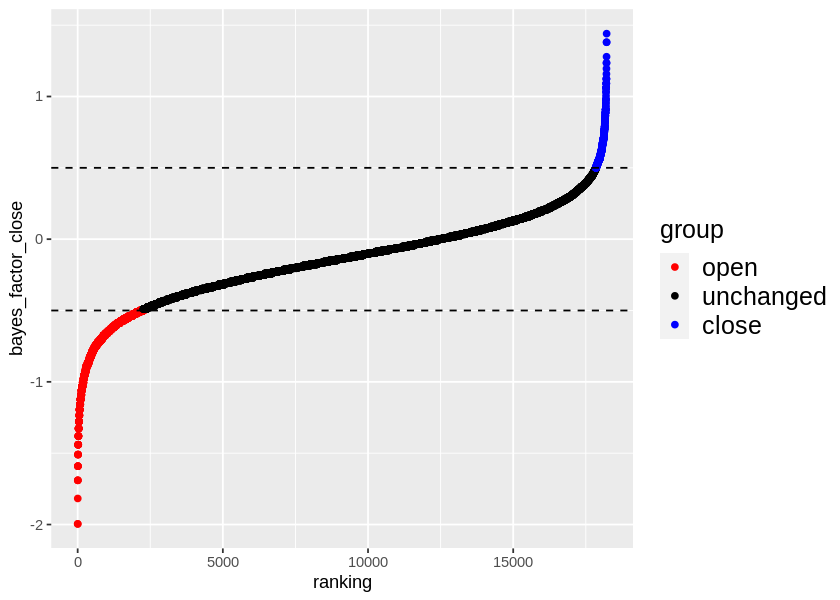

In [303]:
options(repr.plot.width=7, repr.plot.height=5)
df %>%
  ggplot(aes(x = ranking, y = bayes_factor_close, col = group)) +
    geom_point() +
    geom_hline(yintercept = c(0.5, -0.5), linetype="dashed", size = 0.5) +
    scale_color_manual(values = c('close' = 'blue', 'unchanged' = 'black', 'open' = 'red')) +
    theme(
      legend.title = element_text(size = 15),
      legend.text = element_text(size = 15)
    )


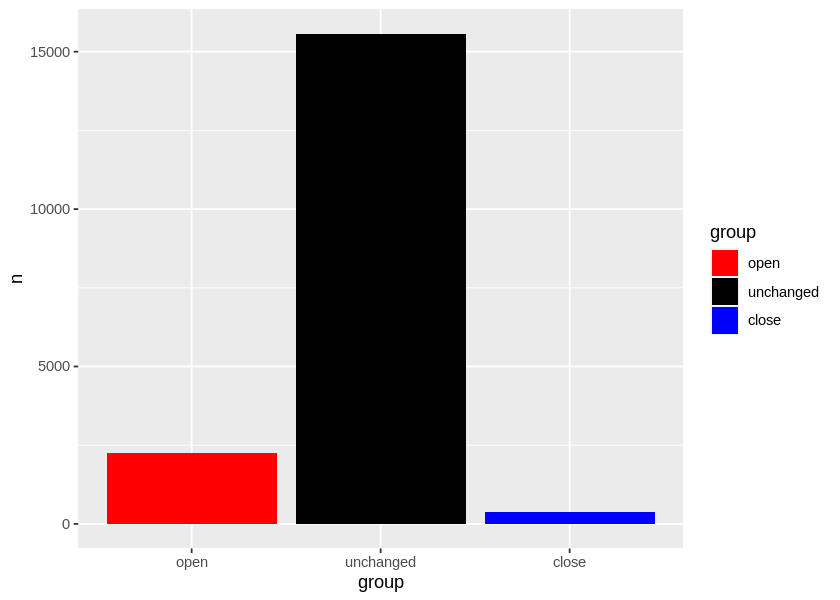

In [304]:
options(repr.plot.width=7, repr.plot.height=5)
df %>%
  group_by(group) %>%
  tally() %>%
  ggplot(aes(x = group, y = n, fill = group)) +
    geom_bar(stat = 'identity') +
    scale_fill_manual(values = c('close' = 'blue', 'unchanged' = 'black', 'open' = 'red'))

In [305]:
for (i in c('close', 'unchanged', 'open')){
  sprintf('status=%s | n=%d', i, sum(df$group == i)) %>% message()
}

status=close | n=378

status=unchanged | n=15573

status=open | n=2267



## Plot aggregated V-plots that become *closed* in D1 compared with MEF

dimnames(.) <- NULL:  translated to 
dimnames(.) <- list(NULL,NULL)  <==>  unname(.)

dimnames(.) <- NULL:  translated to 
dimnames(.) <- list(NULL,NULL)  <==>  unname(.)

dimnames(.) <- NULL:  translated to 
dimnames(.) <- list(NULL,NULL)  <==>  unname(.)

dimnames(.) <- NULL:  translated to 
dimnames(.) <- list(NULL,NULL)  <==>  unname(.)

dimnames(.) <- NULL:  translated to 
dimnames(.) <- list(NULL,NULL)  <==>  unname(.)

dimnames(.) <- NULL:  translated to 
dimnames(.) <- list(NULL,NULL)  <==>  unname(.)

dimnames(.) <- NULL:  translated to 
dimnames(.) <- list(NULL,NULL)  <==>  unname(.)

dimnames(.) <- NULL:  translated to 
dimnames(.) <- list(NULL,NULL)  <==>  unname(.)



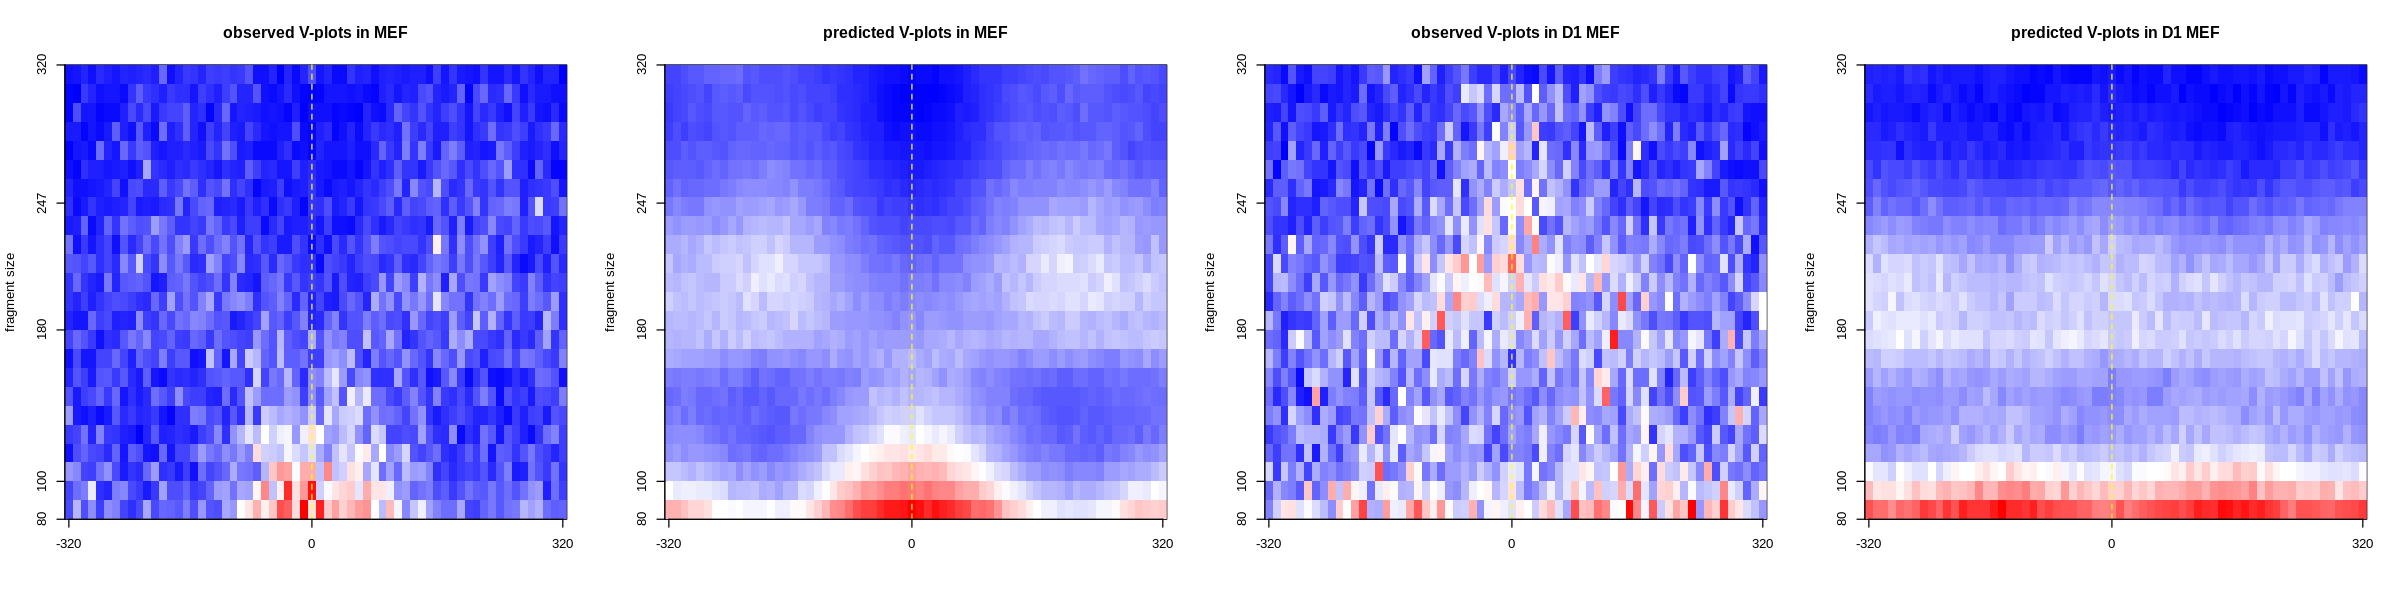

In [306]:
options(repr.plot.width=20, repr.plot.height=5)
par(mfrow = c(1, 4))

i <- rowData(x_center)$batch == 'MEF_NoDox' & 
  !is.na(rowData(x_center)[['MEF_Dox_D1,MEF_NoDox']]$bayes_factor_close) & 
  rowData(x_center)[['MEF_Dox_D1,MEF_NoDox']]$bayes_factor_close > 0.5

x_center[i] %>% vplot(main = 'observed V-plots in MEF')
  
predict_vplots(model, x_center[i]) %>% 
  vplot(field = 'predicted_counts', main = 'predicted V-plots in MEF')


i <- rowData(x_center)$batch == 'MEF_Dox_D1' & 
  !is.na(rowData(x_center)[['MEF_Dox_D1,MEF_NoDox']]$bayes_factor_close) & 
  rowData(x_center)[['MEF_Dox_D1,MEF_NoDox']]$bayes_factor_close > 0.5

x_center[i] %>% vplot(main = 'observed V-plots in D1 MEF')
  
predict_vplots(model, x_center[i]) %>% 
  vplot(field = 'predicted_counts', main = 'predicted V-plots in D1 MEF')

## Plot aggregated V-plots that become *open* in D1 compared with MEF

dimnames(.) <- NULL:  translated to 
dimnames(.) <- list(NULL,NULL)  <==>  unname(.)

dimnames(.) <- NULL:  translated to 
dimnames(.) <- list(NULL,NULL)  <==>  unname(.)

dimnames(.) <- NULL:  translated to 
dimnames(.) <- list(NULL,NULL)  <==>  unname(.)

dimnames(.) <- NULL:  translated to 
dimnames(.) <- list(NULL,NULL)  <==>  unname(.)

dimnames(.) <- NULL:  translated to 
dimnames(.) <- list(NULL,NULL)  <==>  unname(.)

dimnames(.) <- NULL:  translated to 
dimnames(.) <- list(NULL,NULL)  <==>  unname(.)

dimnames(.) <- NULL:  translated to 
dimnames(.) <- list(NULL,NULL)  <==>  unname(.)

dimnames(.) <- NULL:  translated to 
dimnames(.) <- list(NULL,NULL)  <==>  unname(.)



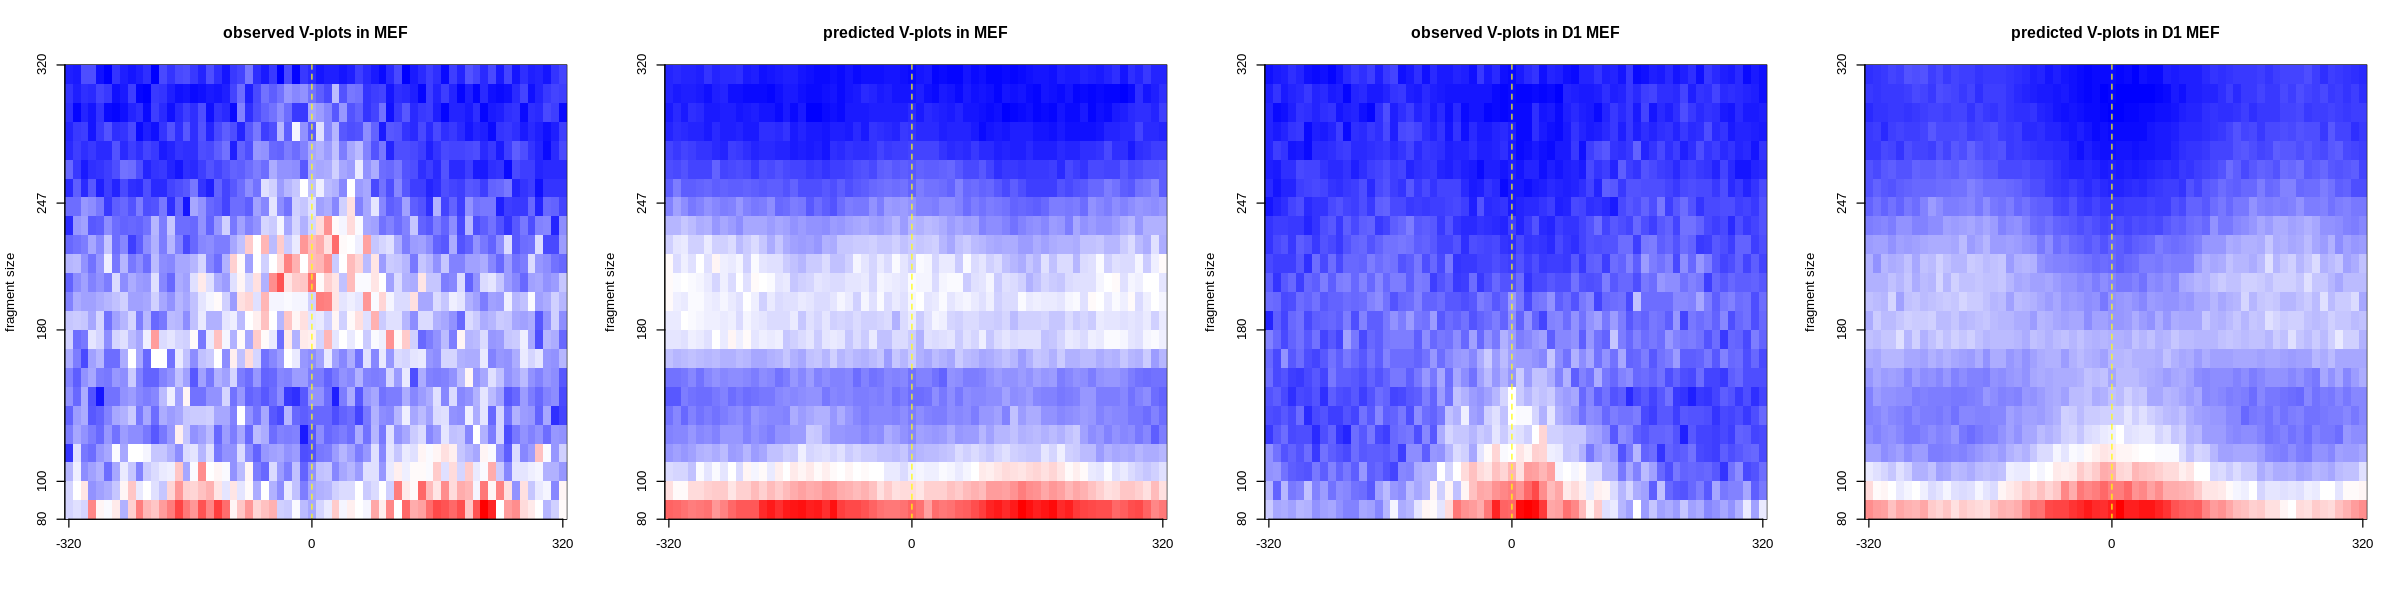

In [307]:
options(repr.plot.width=20, repr.plot.height=5)
par(mfrow = c(1, 4))


i <- rowData(x_center)$batch == 'MEF_NoDox' & 
  !is.na(rowData(x_center)[['MEF_Dox_D1,MEF_NoDox']]$bayes_factor_open) & 
  rowData(x_center)[['MEF_Dox_D1,MEF_NoDox']]$bayes_factor_open > 0.5

x_center[i] %>% vplot(main = 'observed V-plots in MEF')
  
predict_vplots(model, x_center[i]) %>% 
  vplot(field = 'predicted_counts', main = 'predicted V-plots in MEF')


i <- rowData(x_center)$batch == 'MEF_Dox_D1' & 
  !is.na(rowData(x_center)[['MEF_Dox_D1,MEF_NoDox']]$bayes_factor_open) & 
  rowData(x_center)[['MEF_Dox_D1,MEF_NoDox']]$bayes_factor_open > 0.5

x_center[i] %>% vplot(main = 'observed V-plots in D1 MEF')
  
predict_vplots(model, x_center[i]) %>% 
  vplot(field = 'predicted_counts', main = 'predicted V-plots in D1 MEF')

## Top Vplots that become closed in D1 MEF

In [314]:
df <- cbind(
    seqnames = seqnames(x_center),
    start = start(x_center),
    end = end(x_center),
    id = rowData(x_center)$id, 
    batch = rowData(x_center)$batch, rowData(x_center)[['MEF_Dox_D1,MEF_NoDox']]
  ) %>% 
  filter(batch == 'MEF_Dox_D1') %>%
  filter(!is.na(bayes_factor_close)) %>%
  arrange(desc(bayes_factor_close)) %>%
  head(5L)
df

,seqnames,start,end,id,batch,bayes_factor_close,bayes_factor_open
,<fct>,<int>,<int>,<int>,<chr>,<dbl>,<dbl>
1,chrX,74244588,74245227,121810,MEF_Dox_D1,1.440459,-1.440459
2,chr2,25332283,25332922,66563,MEF_Dox_D1,1.380211,-1.380211
3,chr9,103111466,103112105,119393,MEF_Dox_D1,1.380211,-1.380211
4,chr1,182368603,182369242,6892,MEF_Dox_D1,1.278753,-1.278753
5,chr17,56022097,56022736,55476,MEF_Dox_D1,1.235069,-1.235069


dimnames(.) <- NULL:  translated to 
dimnames(.) <- list(NULL,NULL)  <==>  unname(.)

dimnames(.) <- NULL:  translated to 
dimnames(.) <- list(NULL,NULL)  <==>  unname(.)

dimnames(.) <- NULL:  translated to 
dimnames(.) <- list(NULL,NULL)  <==>  unname(.)

dimnames(.) <- NULL:  translated to 
dimnames(.) <- list(NULL,NULL)  <==>  unname(.)

dimnames(.) <- NULL:  translated to 
dimnames(.) <- list(NULL,NULL)  <==>  unname(.)

dimnames(.) <- NULL:  translated to 
dimnames(.) <- list(NULL,NULL)  <==>  unname(.)

dimnames(.) <- NULL:  translated to 
dimnames(.) <- list(NULL,NULL)  <==>  unname(.)

dimnames(.) <- NULL:  translated to 
dimnames(.) <- list(NULL,NULL)  <==>  unname(.)

dimnames(.) <- NULL:  translated to 
dimnames(.) <- list(NULL,NULL)  <==>  unname(.)

dimnames(.) <- NULL:  translated to 
dimnames(.) <- list(NULL,NULL)  <==>  unname(.)

dimnames(.) <- NULL:  translated to 
dimnames(.) <- list(NULL,NULL)  <==>  unname(.)

dimnames(.) <- NULL:  translated to 
dimnames(.) <- li

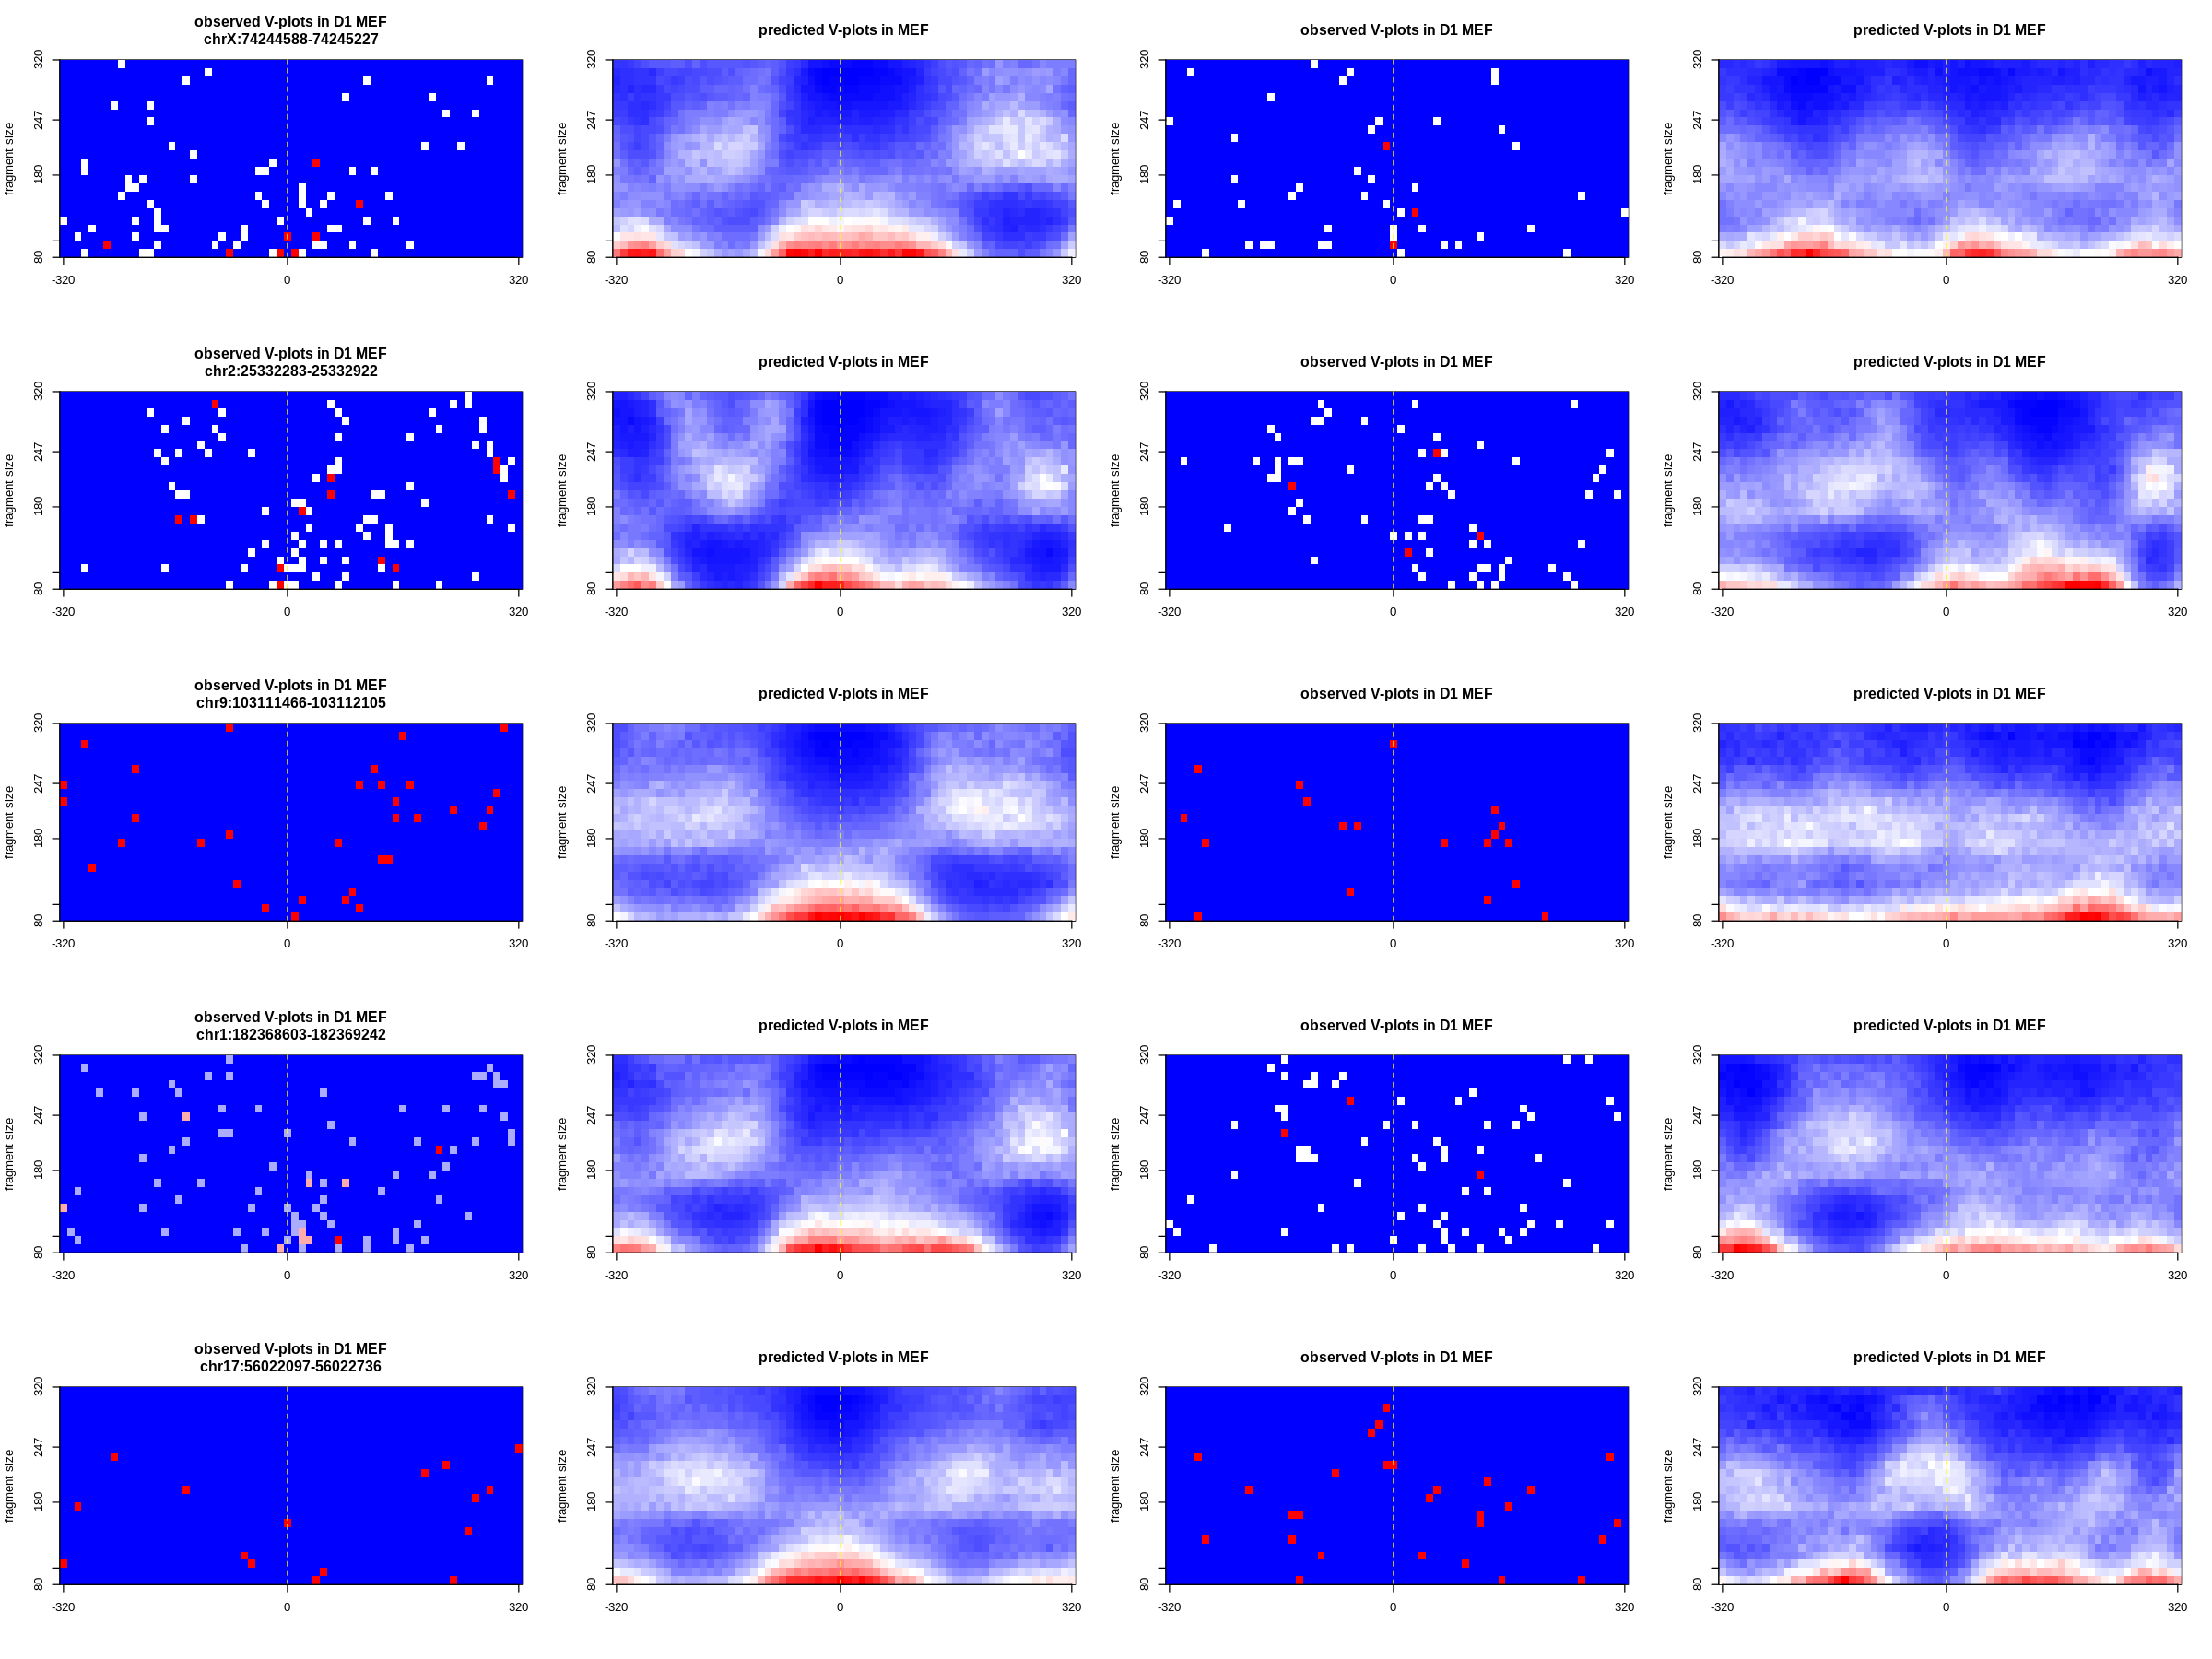

In [315]:
options(repr.plot.width=20, repr.plot.height= 3 * nrow(df))
par(mfrow = c(nrow(df), 4))

for (id in df$id){  
  i <- rowData(x_center)$id == id & rowData(x_center)$batch == 'MEF_NoDox' 
  x_center[i] %>% 
    vplot(main = sprintf('observed V-plots in D1 MEF\n%s:%d-%d', seqnames(x_center[i]), start(x_center[i]), end (x_center[i])))
  predict_vplots(model, x_center[i]) %>% 
    vplot(field = 'predicted_counts', main = 'predicted V-plots in MEF')
  i <- rowData(x_center)$id == id & rowData(x_center)$batch == 'MEF_Dox_D1' 
  x_center[i] %>% vplot(main = 'observed V-plots in D1 MEF')
  predict_vplots(model, x_center[i]) %>% 
    vplot(field = 'predicted_counts', main = 'predicted V-plots in D1 MEF')
}

## Top 5 Vplots that become open in D1 MEF

In [316]:
df <- cbind(
    seqnames = seqnames(x_center),
    start = start(x_center),
    end = end(x_center),
    id = rowData(x_center)$id, 
    batch = rowData(x_center)$batch, rowData(x_center)[['MEF_Dox_D1,MEF_NoDox']]
  ) %>% 
  filter(batch == 'MEF_Dox_D1') %>%
  filter(!is.na(bayes_factor_close)) %>%
  arrange(desc(bayes_factor_open)) %>%
  head(5L)
df

,seqnames,start,end,id,batch,bayes_factor_close,bayes_factor_open
,<fct>,<int>,<int>,<int>,<chr>,<dbl>,<dbl>
1,chr1,194995068,194995707,7534,MEF_Dox_D1,-1.995635,1.995635
2,chr7,111083000,111083639,105504,MEF_Dox_D1,-1.995635,1.995635
3,chr19,23140615,23141254,63109,MEF_Dox_D1,-1.817345,1.817345
4,chr1,88662825,88663464,3363,MEF_Dox_D1,-1.690196,1.690196
5,chr18,12647968,12648607,58645,MEF_Dox_D1,-1.690196,1.690196


dimnames(.) <- NULL:  translated to 
dimnames(.) <- list(NULL,NULL)  <==>  unname(.)

dimnames(.) <- NULL:  translated to 
dimnames(.) <- list(NULL,NULL)  <==>  unname(.)

dimnames(.) <- NULL:  translated to 
dimnames(.) <- list(NULL,NULL)  <==>  unname(.)

dimnames(.) <- NULL:  translated to 
dimnames(.) <- list(NULL,NULL)  <==>  unname(.)

dimnames(.) <- NULL:  translated to 
dimnames(.) <- list(NULL,NULL)  <==>  unname(.)

dimnames(.) <- NULL:  translated to 
dimnames(.) <- list(NULL,NULL)  <==>  unname(.)

dimnames(.) <- NULL:  translated to 
dimnames(.) <- list(NULL,NULL)  <==>  unname(.)

dimnames(.) <- NULL:  translated to 
dimnames(.) <- list(NULL,NULL)  <==>  unname(.)

dimnames(.) <- NULL:  translated to 
dimnames(.) <- list(NULL,NULL)  <==>  unname(.)

dimnames(.) <- NULL:  translated to 
dimnames(.) <- list(NULL,NULL)  <==>  unname(.)

dimnames(.) <- NULL:  translated to 
dimnames(.) <- list(NULL,NULL)  <==>  unname(.)

dimnames(.) <- NULL:  translated to 
dimnames(.) <- li

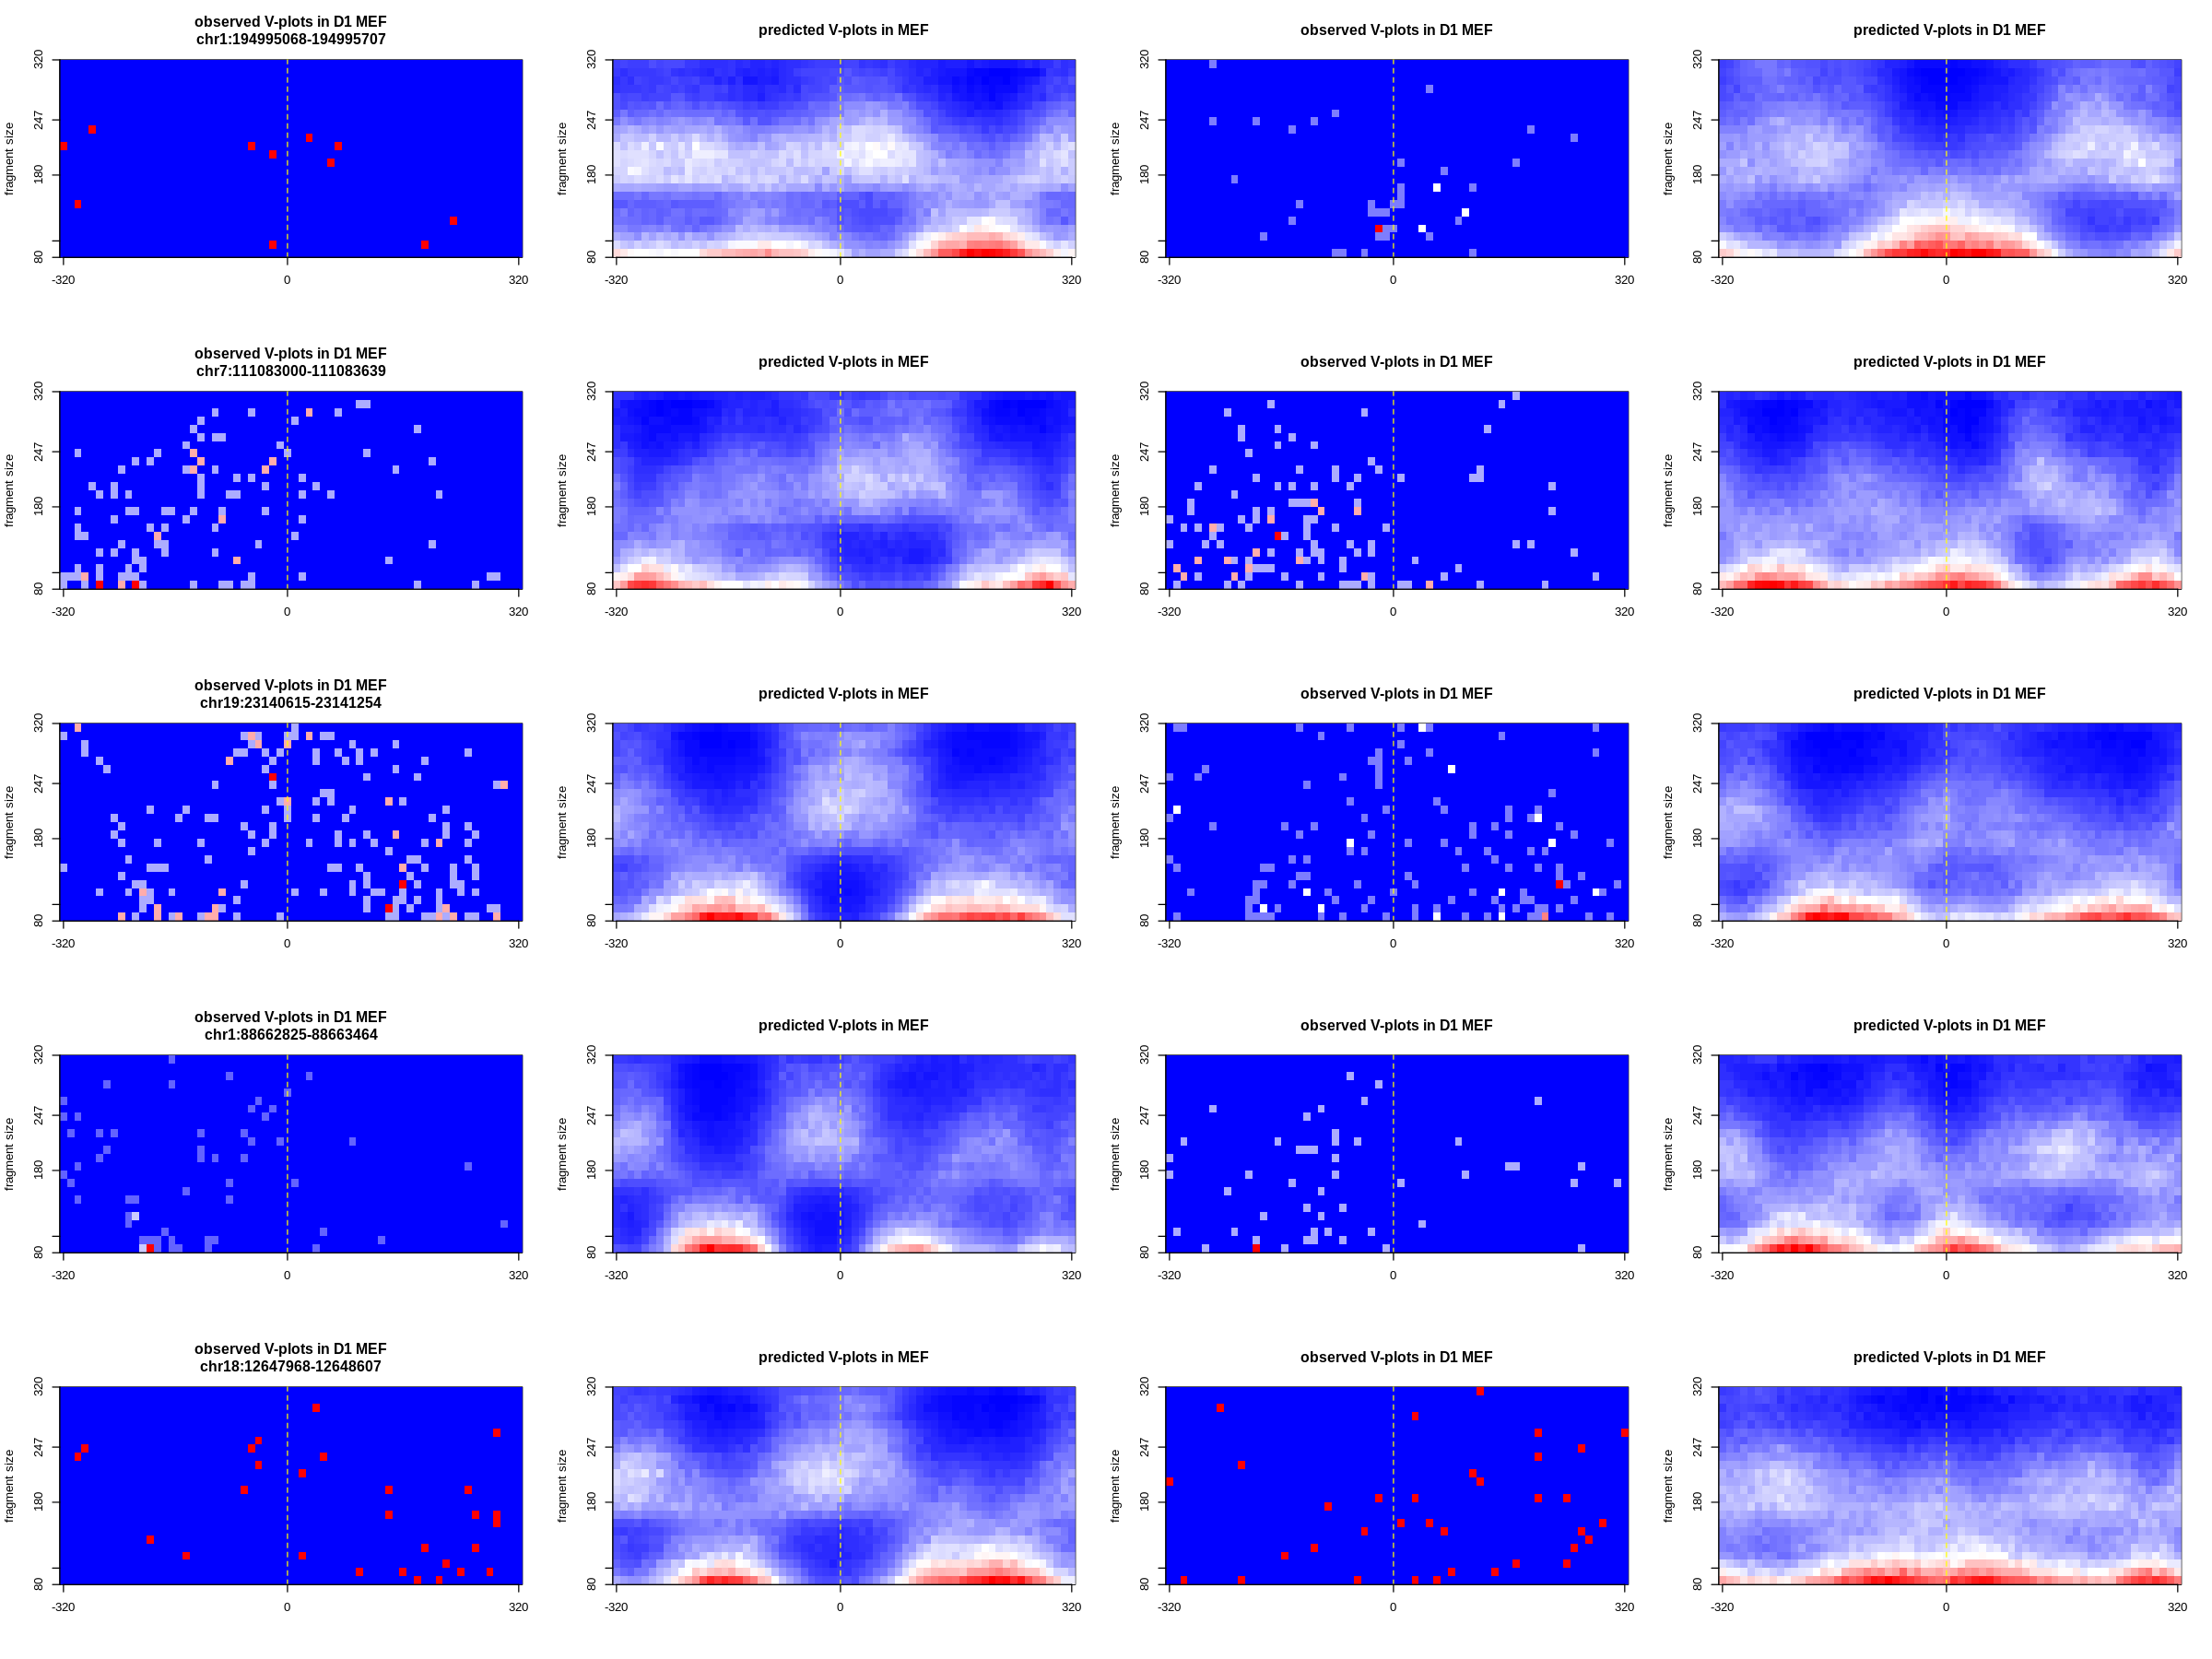

In [317]:
options(repr.plot.width=20, repr.plot.height=3 * nrow(df))
par(mfrow = c(nrow(df), 4))

for (id in df$id){  
  i <- rowData(x_center)$id == id & rowData(x_center)$batch == 'MEF_NoDox' 
  x_center[i] %>% 
    vplot(main = sprintf('observed V-plots in D1 MEF\n%s:%d-%d', seqnames(x_center[i]), start(x_center[i]), end (x_center[i])))
  predict_vplots(model, x_center[i]) %>% 
    vplot(field = 'predicted_counts', main = 'predicted V-plots in MEF')
  i <- rowData(x_center)$id == id & rowData(x_center)$batch == 'MEF_Dox_D1' 
  x_center[i] %>% vplot(main = 'observed V-plots in D1 MEF')
  predict_vplots(model, x_center[i]) %>% 
    vplot(field = 'predicted_counts', main = 'predicted V-plots in D1 MEF')
}

In [ ]:
sessionInfo()

In [ ]:
Sys.time() - start_time0